In [1]:
import os
import pandas as pd

In [2]:
os.chdir('C:/Users/HK/Desktop/LAB/RNN/S2S')

### 데이터 준비

In [3]:
lines = pd.read_table('fra.txt', names = ['source', 'target'])

In [4]:
print(len(lines), 'observations')
lines = lines.head(10000) # 메모리 문제로 10000개만 사용
lines.sample(10)

170190 observations


,source,target
6548,Tom's healthy.,Tom est en bonne santé.
8928,They found out.,Ils ont découvert la chose.
2497,I'm touched.,Je suis touché.
6286,Take a shower.,Prends une douche !
7230,Don't be sorry.,Ne soyez pas désolés !
5781,I'm not a kid.,Je ne suis pas un enfant.
4654,You're early.,Vous êtes matinale.
8549,Let Tom answer.,Laissez Tom répondre.
5170,I am not deaf.,Je ne suis pas sourd.
6618,We met before.,Nous nous sommes rencontrés auparavant.


In [5]:
# 문장의 시작을 의미하는 '\t'
# 문장의 종료를 의미하는 '\n'를 각 문장 앞뒤에 추가히기

lines.target = lines.target.apply(lambda x : '\t' + x + '\n')
lines.sample(10)

,source,target
6511,Tom let us go.,\tTom nous a laissé partir.\n
7142,Did you see it?,\tL'as-tu vu ?\n
1621,Stay still.,\tNe bouge pas.\n
8918,They all drank.,\tElles ont toutes bu.\n
2719,Stay in bed.,\tReste alité !\n
5876,Is it serious?,\tC'est grave ?\n
7247,Don't buy that.,\tN'achète pas ça.\n
3644,I need money.,\tJ'ai besoin d'argent.\n
9429,Who's watching?,\tQui est en train de regarder ?\n
138,He quit.,\tIl laissa tomber.\n


In [6]:
# 글자집합 구축
# source, target 시퀀스 각각 사전(글자집합)에 글자 추가

source_vocab = set()
for line in lines.source: # 문장 한 줄씩 읽음
    for char in line:     # 글자 한 개씩 읽음
        source_vocab.add(char)
        
target_vocab = set()
for line in lines.target: 
    for char in line:     
        target_vocab.add(char)        

In [7]:
source_vocab_size = len(source_vocab) +1
target_vocab_size = len(target_vocab) +1

print('source 글자 개수:', source_vocab_size)
print('target 글자 개수:', target_vocab_size)

source 글자 개수: 71
target 글자 개수: 94


In [8]:
# 집합을 리스트로 변환하고 정렬

source_vocab = sorted(list(source_vocab))
target_vocab = sorted(list(target_vocab))

print(source_vocab[10:20])
print(target_vocab[10:20])

['1', '2', '3', '5', '6', '7', '8', '9', ':', '?']
[',', '-', '.', '0', '1', '2', '3', '5', '8', '9']


In [9]:
# 각 사전의 글자에 인덱스 부여

source_to_index = dict([(word, i+1) for i, word in enumerate(source_vocab)])
target_to_index = dict([(word, i+1) for i, word in enumerate(target_vocab)])

# print(source_to_index)
# print(target_to_index)

In [10]:
# 시퀀스 데이터에 정수 인코딩 (영어 source)

encoder_input = []
for line in lines.source:
    tempX = []
    for w in line:                        # 글자 하나씩
        tempX.append(source_to_index[w])  # 글자에 해당하는 정수 인덱스 추가
    encoder_input.append(tempX)

In [11]:
print(encoder_input[:5])

[[27, 59, 9], [28, 53, 9], [28, 53, 9], [38, 65, 58, 2], [38, 65, 58, 2]]


In [12]:
# 정수 인코딩 (한국어 target)

decoder_input = []
for line in lines.target:
    tempX = []
    for w in line:
        tempX.append(target_to_index[w])
    decoder_input.append(tempX)

In [13]:
# 디코더의 예측 값과 비교하기 위한 실제 값 인코딩
# 여기서는 시작 심볼 '\t'가 있을 필요가 없음 (사전에서 0:'\t')

decoder_target = []
for line in lines.target:
    t = 0
    tempX = []
    for w in line:
        if t > 0:
            tempX.append(target_to_index[w])
        t = t + 1
    decoder_target.append(tempX)

In [14]:
max_source_len = max([len(line) for line in lines.source])
max_target_len = max([len(line) for line in lines.target])

print('source 최대 문장길이:', max_source_len)
print('target 최대 문장길이:', max_target_len)

source 최대 문장길이: 16
target 최대 문장길이: 59


In [15]:
# 시퀀스-투-시퀀스 모델에서 데이터 하나의 쌍끼리는 길이가 같을 필요는 없음
# source 시퀀스, target 시퀀스끼리 각각 길이를 맞춰서 패딩하면 됨

# source/target 별로 가장 최대길이에 맞춰서 패딩 (앞에 채우기)

from keras.preprocessing.sequence import pad_sequences

encoder_input = pad_sequences(encoder_input, max_source_len, padding = 'post')
decoder_input = pad_sequences(decoder_input, max_target_len, padding = 'post')
decoder_target = pad_sequences(decoder_target, max_target_len, padding = 'post')

Using TensorFlow backend.


In [16]:
# 원-핫 인코딩
# 글자 단위 번역기이므로 워드 임베딩 사용 안함

from keras.utils.np_utils import to_categorical

encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

### SEQ2SEQ 기계번역기 훈련시키기 (교사학습)

In [17]:
from keras.layers import Input, GRU, LSTM, Embedding, Dense
from keras.models import Model, load_model, save_model
from keras import optimizers
import keras.backend as K

In [18]:
K.clear_session()

In [19]:
rnn_units = 128

In [20]:
# 인코더 설계

encoder_inputs = Input(shape = (None, source_vocab_size))
encoder_lstm = LSTM(units = rnn_units, return_state = True)
# 인코더의 내부 상태를 디코더로 넘겨줘야 하므로 state도 같이 리턴함

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs는 리턴받지만 여기서는 필요없음

encoder_states = [state_h, state_c]
# 넘겨줄 인코더 statee들 (LSTM이라 2개) : 이것이 곧 컨텍스트(context) 백터

In [21]:
# 디코더 설계

decoder_inputs = Input(shape = (None, target_vocab_size))
decoder_lstm = LSTM(units = rnn_units, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 함
# 디코더에서는 리턴되는 값 중 output만 필요함

decoder_softmax_layer = Dense(target_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [22]:
# 모형 설계

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# 인코더 입력과 디코더 입력을 받아서 디코더 출력

model.compile(optimizer = optimizers.adam(),
              loss = "categorical_crossentropy",
              metrics = ['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 94)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 102400      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  114176      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [23]:
epochs = 100
batch_size = 128

history = model.fit([encoder_input, decoder_input], decoder_target,
                    validation_split = 0.2,
                    epochs = epochs, batch_size = batch_size, verbose = 2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 20s - loss: 2.0867 - acc: 0.6587 - val_loss: 1.4720 - val_acc: 0.6700
Epoch 2/100
 - 18s - loss: 1.1223 - acc: 0.7185 - val_loss: 1.1418 - val_acc: 0.6903
Epoch 3/100
 - 19s - loss: 0.9768 - acc: 0.7338 - val_loss: 1.0610 - val_acc: 0.7042
Epoch 4/100
 - 23s - loss: 0.9096 - acc: 0.7525 - val_loss: 1.0049 - val_acc: 0.7275
Epoch 5/100
 - 25s - loss: 0.8571 - acc: 0.7673 - val_loss: 0.9492 - val_acc: 0.7411
Epoch 6/100
 - 24s - loss: 0.8019 - acc: 0.7830 - val_loss: 0.8903 - val_acc: 0.7579
Epoch 7/100
 - 19s - loss: 0.7451 - acc: 0.7970 - val_loss: 0.8306 - val_acc: 0.7700
Epoch 8/100
 - 19s - loss: 0.6935 - acc: 0.8068 - val_loss: 0.7770 - val_acc: 0.7809
Epoch 9/100
 - 20s - loss: 0.6504 - acc: 0.8173 - val_loss: 0.7350 - val_acc: 0.7913
Epoch 10/100
 - 24s - loss: 0.6178 - acc: 0.8250 - val_loss: 0.7054 - val_acc: 0.7980
Epoch 11/100
 - 29s - loss: 0.5944 - acc: 0.8298 - val_loss: 0.6804 - val_acc: 0.8055
Epoch 12/100
 -

Epoch 96/100
 - 19s - loss: 0.2254 - acc: 0.9326 - val_loss: 0.5021 - val_acc: 0.8643
Epoch 97/100
 - 20s - loss: 0.2221 - acc: 0.9339 - val_loss: 0.5012 - val_acc: 0.8650
Epoch 98/100
 - 23s - loss: 0.2206 - acc: 0.9343 - val_loss: 0.5059 - val_acc: 0.8642
Epoch 99/100
 - 29s - loss: 0.2186 - acc: 0.9347 - val_loss: 0.5066 - val_acc: 0.8644
Epoch 100/100
 - 26s - loss: 0.2175 - acc: 0.9352 - val_loss: 0.5108 - val_acc: 0.8637


In [30]:
import matplotlib.pyplot as plt

def history_plot(history, model = 1):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = [i for i in range(len(acc))]
    
    plt.plot(epochs, loss, '-k', label = 'Training')
    plt.plot(epochs, val_loss, ':r', label = 'Validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(epochs, acc, '-k', label = 'Training')
    plt.plot(epochs, val_acc, ':r', label = 'Validation')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

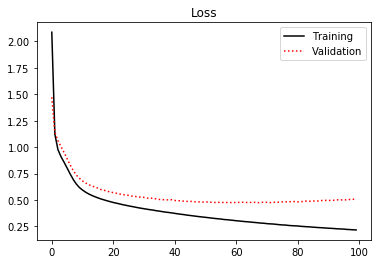

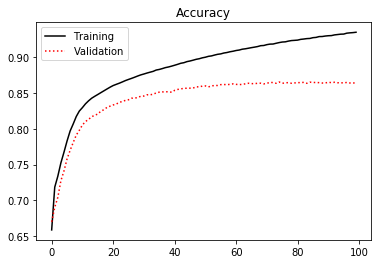

In [31]:
history_plot(history)

### 기계번역 동작 (예측)

In [26]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (rnn_units,))
decoder_state_input_c = Input(shape = (rnn_units,))
decoder_states_inputs_p = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs_p, state_h_p, state_c_p = decoder_lstm(
    decoder_inputs, initial_state = decoder_states_inputs_p)

decoder_states_p = [state_h_p, state_c_p]
decoder_outputs_p = decoder_softmax_layer(decoder_outputs_p)

decoder_model = Model([decoder_inputs] + decoder_states_inputs_p, [decoder_outputs_p] + decoder_states_p)

In [27]:
index_to_source = dict((i, char) for char, i in source_to_index.items())
index_to_target = dict((i, char) for char, i in target_to_index.items())

In [28]:
def decode_sentence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # 문장 시작에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, target_vocab_size))
    target_seq[0, 0, target_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition: 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_target[sampled_token_index]
        decoded_sentence += sampled_char
        
        # 문장 끝에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_target_len):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1, target_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 상태를 업데이트
        states_value = [h, c]

    return decoded_sentence

In [34]:
import numpy as np

for i in np.random.randint(0, len(lines) - 1, size = 3):
    input_sequence = encoder_input[i:i + 1]
    decoded_sentence = decode_sentence(input_sequence)
    
    print(50 * '-')
    print('입력 문장:', lines.source[i])
    print('정답 문장:', lines.target[i][1:len(lines.target[i]) - 1])
    print('번역기:', decoded_sentence)

--------------------------------------------------
입력 문장: I'll get it.
정답 문장: Je vais aller le chercher.
번역기: J'achiterai.

--------------------------------------------------
입력 문장: I'm grounded.
정답 문장: Je suis cloué.
번역기: Je suis pristé.

--------------------------------------------------
입력 문장: What a mess!
정답 문장: Quelle pagaille !
번역기: Quel moure !

